# HR Analytics - Employee Attrition Prediction with Logistic Regression

This notebook analyzes the HR Analytics dataset and trains a Logistic Regression model to predict employee attrition.


## 1. Import Libraries


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score
)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load and Explore Data


In [22]:
# Load the dataset
try:
    df = pd.read_csv('data/HR_Analytics.csv')
except FileNotFoundError:
    print("Error: The file 'data/HR_Analytics.csv' does not exist. Please download the dataset from the provided link.")
    df = pd.DataFrame()

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset Shape: (1480, 38)

First few rows:


,EmpID,Age,AgeGroup,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,230,Research & Development,3,3,Life Sciences,...,3,80,0,0,2,3,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,812,Sales,10,3,Medical,...,1,80,0,0,2,3,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,1306,Sales,5,3,Marketing,...,4,80,0,0,3,3,0,0,0,0.0
3,RM728,18,18-25,No,Non-Travel,287,Research & Development,5,2,Life Sciences,...,4,80,0,0,2,3,0,0,0,0.0
4,RM829,18,18-25,Yes,Non-Travel,247,Research & Development,8,1,Medical,...,4,80,0,0,0,3,0,0,0,0.0


Attrition Distribution:
Attrition
No     1242
Yes     238
Name: count, dtype: int64

Attrition Percentage:
Attrition
No     83.918919
Yes    16.081081
Name: proportion, dtype: float64


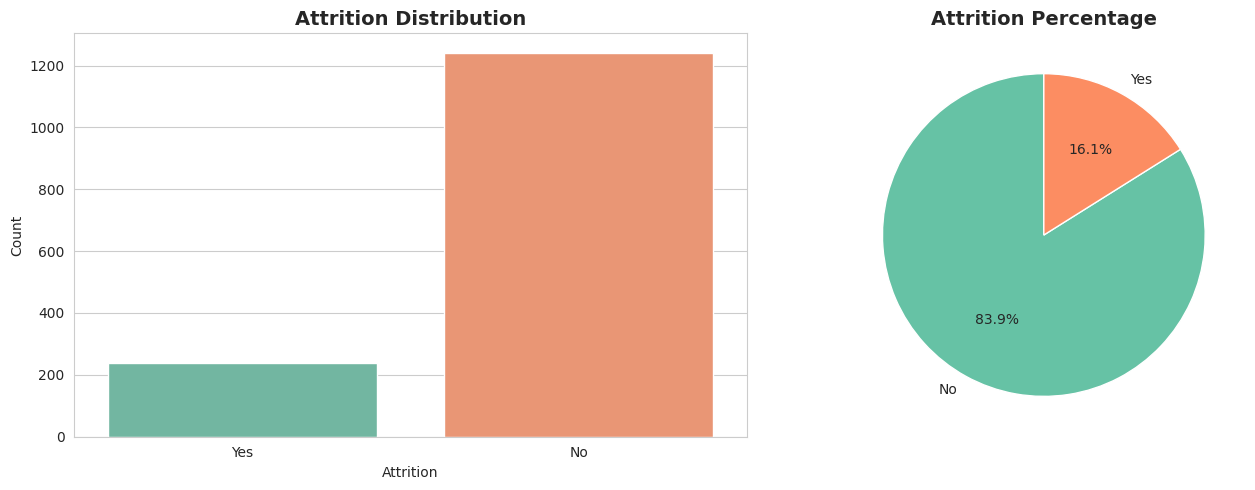

In [23]:
# Check target variable distribution
print("Attrition Distribution:")
print(df['Attrition'].value_counts())
print("\nAttrition Percentage:")
print(df['Attrition'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='Attrition', ax=axes[0], palette='Set2')
axes[0].set_title('Attrition Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')

# Pie chart
attrition_counts = df['Attrition'].value_counts()
axes[1].pie(attrition_counts, labels=attrition_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('Set2'))
axes[1].set_title('Attrition Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./output/logistic/attrition_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Data Preprocessing


In [24]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop irrelevant columns
columns_to_drop = ['EmpID', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print(f"Columns after dropping irrelevant features: {df_processed.shape[1]}")
print("\nRemaining columns:")
print(df_processed.columns.tolist())


Columns after dropping irrelevant features: 33

Remaining columns:
['Age', 'AgeGroup', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'SalarySlab', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [25]:
# Encode categorical variables
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns to encode: {len(categorical_columns)}")
print(categorical_columns)

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nEncoding completed!")


Categorical columns to encode: 10
['AgeGroup', 'Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'SalarySlab', 'OverTime']
Encoded AgeGroup: {'18-25': np.int64(0), '26-35': np.int64(1), '36-45': np.int64(2), '46-55': np.int64(3), '55+': np.int64(4)}
Encoded Attrition: {'No': np.int64(0), 'Yes': np.int64(1)}
Encoded BusinessTravel: {'Non-Travel': np.int64(0), 'TravelRarely': np.int64(1), 'Travel_Frequently': np.int64(2), 'Travel_Rarely': np.int64(3)}
Encoded Department: {'Human Resources': np.int64(0), 'Research & Development': np.int64(1), 'Sales': np.int64(2)}
Encoded EducationField: {'Human Resources': np.int64(0), 'Life Sciences': np.int64(1), 'Marketing': np.int64(2), 'Medical': np.int64(3), 'Other': np.int64(4), 'Technical Degree': np.int64(5)}
Encoded Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded JobRole: {'Healthcare Representative': np.int64(0), 'Human Resources': np.int64(1), 'Laboratory Technician': np.int64(2)

In [26]:
# Handle missing values
# Separate numerical columns for imputation
numerical_columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print("Handling Missing Values...")
print("="*50)

# For numerical columns, we'll use median imputation (more robust to outliers than mean)
imputer = SimpleImputer(strategy='median')

# Check if there are any missing values to impute
if df_processed.isnull().sum().sum() > 0:
    df_processed[numerical_columns] = imputer.fit_transform(df_processed[numerical_columns])
    print(f"✓ Imputed missing values using median strategy")
    print(f"✓ Columns imputed: {len(numerical_columns)}")
    
    # Verify no missing values remain
    remaining_missing = df_processed.isnull().sum().sum()
    print(f"\n✓ Remaining missing values: {remaining_missing}")
else:
    print("No missing values to handle!")

print("\nData preprocessing completed!")


Handling Missing Values...
✓ Imputed missing values using median strategy
✓ Columns imputed: 33

✓ Remaining missing values: 0

Data preprocessing completed!


In [27]:
# Prepare features and target
X = df_processed.drop('Attrition', axis=1)
y = df_processed['Attrition']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())


Features shape: (1480, 32)
Target shape: (1480,)

Target distribution:
Attrition
0.0    1242
1.0     238
Name: count, dtype: int64

Training set size: 1184
Test set size: 296

Training set class distribution:
Attrition
0.0    994
1.0    190
Name: count, dtype: int64

Test set class distribution:
Attrition
0.0    248
1.0     48
Name: count, dtype: int64


In [28]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")


Feature scaling completed!
Scaled training data shape: (1184, 32)
Scaled test data shape: (296, 32)


## 4. Train Logistic Regression Model


In [29]:
# Create Logistic Regression Classifier
logistic_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced',  # Handle class imbalance
    C=1.0  # Regularization parameter
)

print("Logistic Regression Configuration:")
print(f"Solver: {logistic_model.solver}")
#print(f"Max iterations: {logistic_model.max_iter}")
print(f"C (Regularization): {logistic_model.C}")
print(f"Class weight: {logistic_model.class_weight}")
print("\nStarting training...")

# Train the model
logistic_model.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("Training completed!")
print("="*50)
print(f"\nNumber of iterations: {logistic_model.n_iter_[0]}")
print(f"Number of features: {logistic_model.n_features_in_}")


Logistic Regression Configuration:
Solver: lbfgs
C (Regularization): 1.0
Class weight: balanced

Starting training...

Training completed!

Number of iterations: 23
Number of features: 32


## 5. Model Evaluation


In [30]:
# Make predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Get prediction probabilities for ROC curve
y_train_pred_proba = logistic_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTraining F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("\n" + "="*50)


MODEL PERFORMANCE METRICS

Training Accuracy: 0.7551
Test Accuracy: 0.7432

Training F1-Score: 0.5051
Test F1-Score: 0.4648



In [31]:
# Classification Report
print("\nCLASSIFICATION REPORT - TEST SET")
print("="*50)
print(classification_report(y_test, y_test_pred, 
                          target_names=['No Attrition', 'Attrition']))



CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

No Attrition       0.93      0.75      0.83       248
   Attrition       0.35      0.69      0.46        48

    accuracy                           0.74       296
   macro avg       0.64      0.72      0.65       296
weighted avg       0.83      0.74      0.77       296



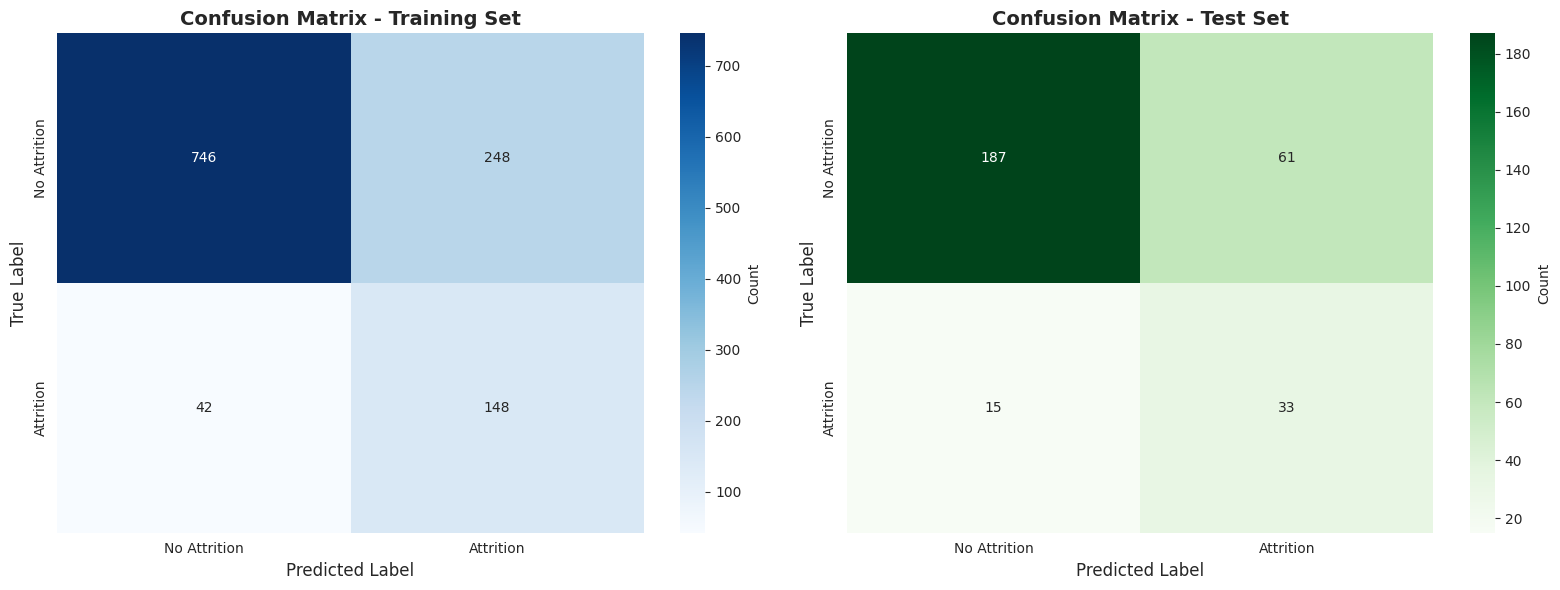

In [32]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Attrition', 'Attrition'],
            yticklabels=['No Attrition', 'Attrition'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Attrition', 'Attrition'],
            yticklabels=['No Attrition', 'Attrition'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('./output/logistic/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


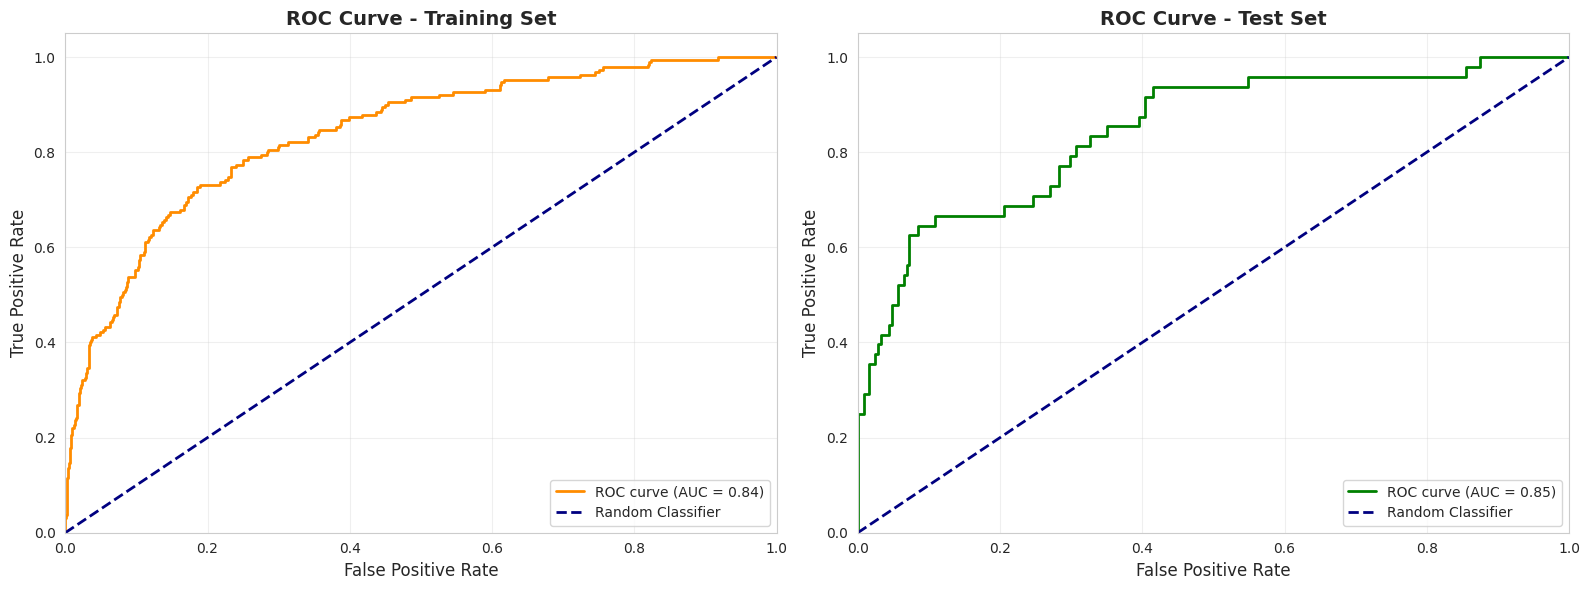


Training AUC-ROC Score: 0.8391
Test AUC-ROC Score: 0.8456


In [33]:
# ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

axes[0].plot(fpr_train, tpr_train, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_train:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Training Set', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Test ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

axes[1].plot(fpr_test, tpr_test, color='green', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_test:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./output/logistic/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining AUC-ROC Score: {roc_auc_train:.4f}")
print(f"Test AUC-ROC Score: {roc_auc_test:.4f}")


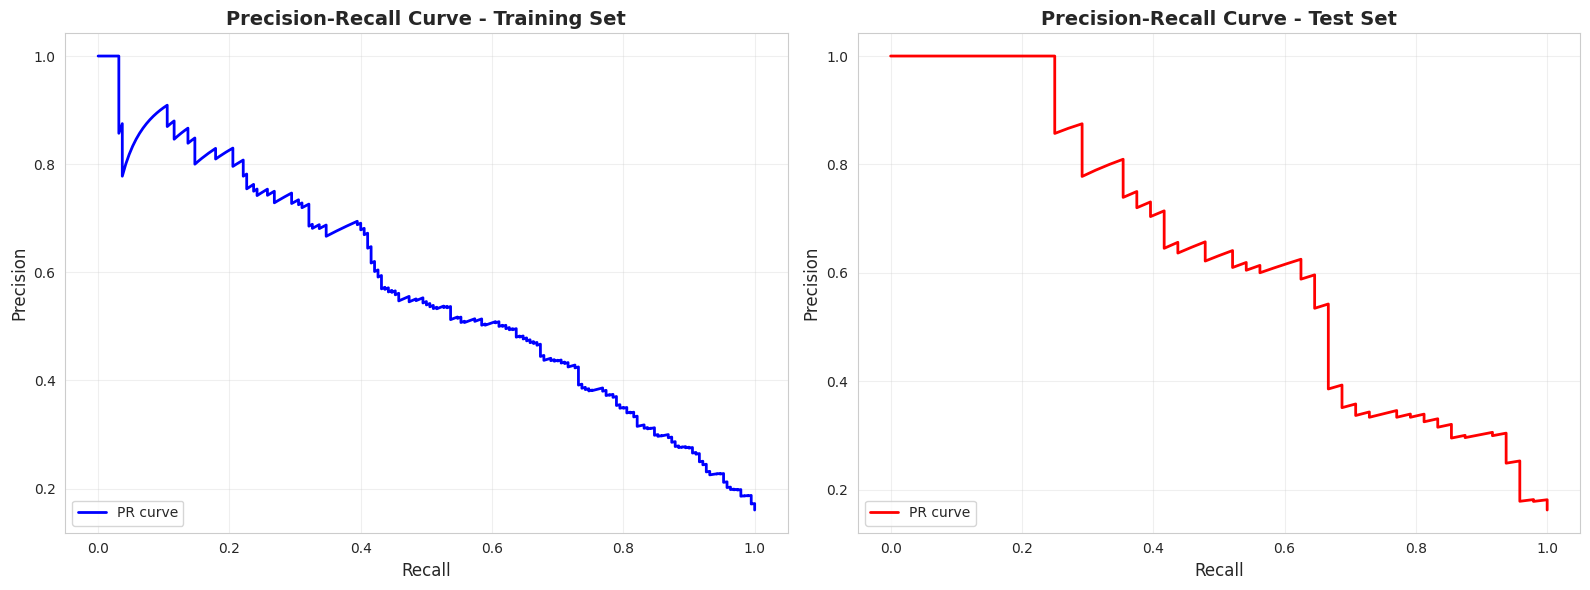

In [34]:
# Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
axes[0].plot(recall_train, precision_train, color='blue', lw=2, label='PR curve')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve - Training Set', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower left")
axes[0].grid(True, alpha=0.3)

# Test Precision-Recall curve
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
axes[1].plot(recall_test, precision_test, color='red', lw=2, label='PR curve')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./output/logistic/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()


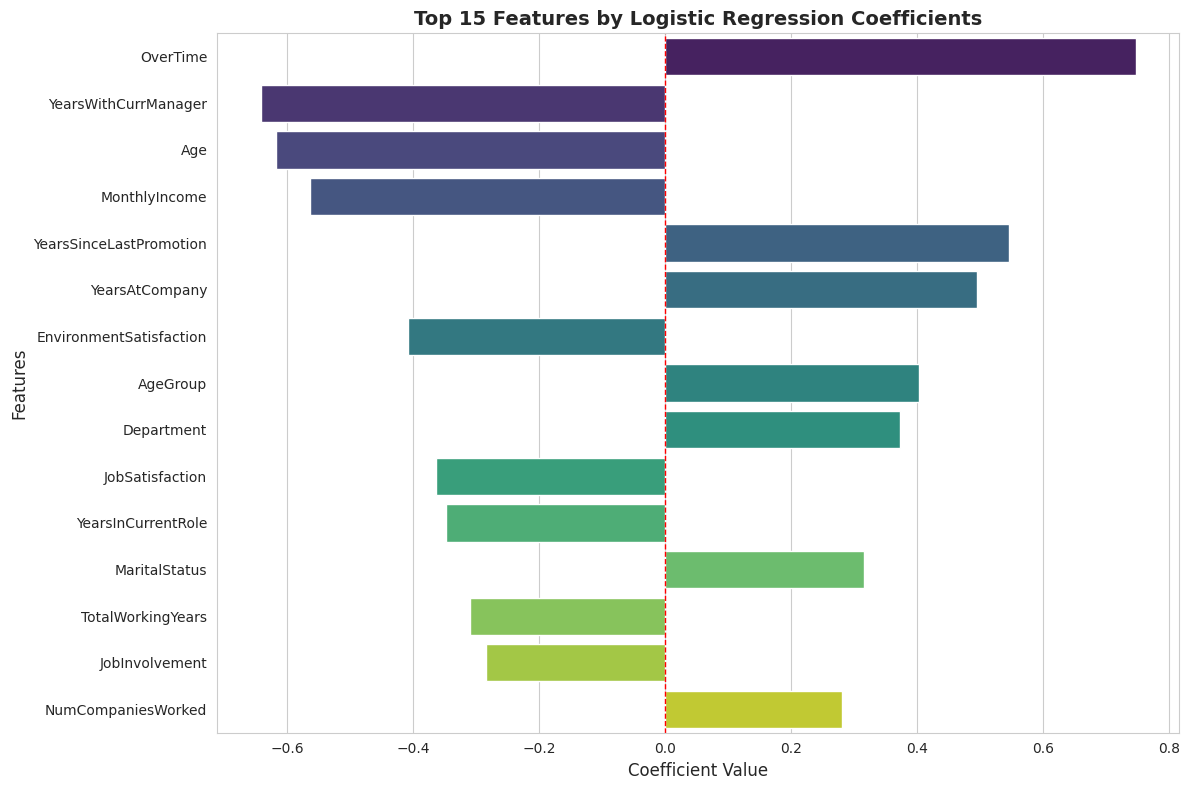


Top 10 Most Important Features (by absolute coefficient):
                    feature  coefficient  abs_coefficient
20                 OverTime     0.747363         0.747363
31     YearsWithCurrManager    -0.641847         0.641847
0                       Age    -0.618420         0.618420
16            MonthlyIncome    -0.564418         0.564418
30  YearsSinceLastPromotion     0.546440         0.546440
28           YearsAtCompany     0.495085         0.495085
8   EnvironmentSatisfaction    -0.407404         0.407404
1                  AgeGroup     0.402857         0.402857
4                Department     0.373426         0.373426
14          JobSatisfaction    -0.363006         0.363006


In [35]:
# Feature Importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logistic_model.coef_[0],
    'abs_coefficient': np.abs(logistic_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='coefficient', palette='viridis')
plt.title('Top 15 Features by Logistic Regression Coefficients', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('./output/logistic/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features (by absolute coefficient):")
print(feature_importance.head(10)[['feature', 'coefficient', 'abs_coefficient']])


## 6. Save Model and Artifacts


In [36]:
# Create output directory if it doesn't exist
output_dir = './output/logistic'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory created: {output_dir}")
print("Saving model and artifacts...")


Output directory created: ./output/logistic
Saving model and artifacts...


In [37]:
# Save the trained Logistic Regression model
model_path = os.path.join(output_dir, 'logistic_attrition_model.pkl')
joblib.dump(logistic_model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save the scaler
scaler_path = os.path.join(output_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save the imputer
imputer_path = os.path.join(output_dir, 'imputer.pkl')
joblib.dump(imputer, imputer_path)
print(f"✓ Imputer saved to: {imputer_path}")

# Save label encoders
encoders_path = os.path.join(output_dir, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"✓ Label encoders saved to: {encoders_path}")

# Save feature names
feature_names_path = os.path.join(output_dir, 'feature_names.pkl')
joblib.dump(X.columns.tolist(), feature_names_path)
print(f"✓ Feature names saved to: {feature_names_path}")

# Save feature importance
feature_importance_path = os.path.join(output_dir, 'feature_importance.csv')
feature_importance.to_csv(feature_importance_path, index=False)
print(f"✓ Feature importance saved to: {feature_importance_path}")


✓ Model saved to: ./output/logistic/logistic_attrition_model.pkl
✓ Scaler saved to: ./output/logistic/scaler.pkl
✓ Imputer saved to: ./output/logistic/imputer.pkl
✓ Label encoders saved to: ./output/logistic/label_encoders.pkl
✓ Feature names saved to: ./output/logistic/feature_names.pkl
✓ Feature importance saved to: ./output/logistic/feature_importance.csv


In [38]:
# Save model performance metrics
metrics = {
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_f1_score': train_f1,
    'test_f1_score': test_f1,
    'train_auc_roc': roc_auc_train,
    'test_auc_roc': roc_auc_test,
    'solver': logistic_model.solver,
    'C': logistic_model.C,
    'class_weight': str(logistic_model.class_weight)
}

metrics_path = os.path.join(output_dir, 'model_metrics.pkl')
joblib.dump(metrics, metrics_path)
print(f"✓ Model metrics saved to: {metrics_path}")

# Save metrics as readable text file
metrics_txt_path = os.path.join(output_dir, 'model_metrics.txt')
with open(metrics_txt_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("LOGISTIC REGRESSION MODEL PERFORMANCE METRICS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Training Accuracy:     {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy:         {test_accuracy:.4f}\n")
    f.write(f"Training F1-Score:     {train_f1:.4f}\n")
    f.write(f"Test F1-Score:         {test_f1:.4f}\n")
    f.write(f"Training AUC-ROC:      {roc_auc_train:.4f}\n")
    f.write(f"Test AUC-ROC:          {roc_auc_test:.4f}\n\n")
    f.write("="*60 + "\n")
    f.write("MODEL CONFIGURATION\n")
    f.write("="*60 + "\n\n")
    f.write(f"Solver:                {logistic_model.solver}\n")
    f.write(f"C (Regularization):    {logistic_model.C}\n")
    f.write(f"Class Weight:          {logistic_model.class_weight}\n")
    f.write(f"Number of Features:    {logistic_model.n_features_in_}\n")
    
print(f"✓ Model metrics (text) saved to: {metrics_txt_path}")


✓ Model metrics saved to: ./output/logistic/model_metrics.pkl
✓ Model metrics (text) saved to: ./output/logistic/model_metrics.txt


In [39]:
# Summary
print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION COMPLETED!")
print("="*60)
print(f"\n📊 Dataset: {df.shape[0]} samples, {df.shape[1]} original features")
print(f"📊 Processed features: {X.shape[1]}")
print(f"📊 Train/Test split: {X_train.shape[0]}/{X_test.shape[0]}")
print(f"\n🧠 Model Type: Logistic Regression")
print(f"🧠 Solver: {logistic_model.solver}")
#print(f"🧠 Training iterations: {logistic_model.max_iter_[0]}")
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test F1-Score: {test_f1:.4f}")
print(f"✅ Test AUC-ROC: {roc_auc_test:.4f}")
print(f"\n💾 All artifacts saved to: {output_dir}/")
print("\nFiles saved:")
print("  - logistic_attrition_model.pkl")
print("  - scaler.pkl")
print("  - imputer.pkl")
print("  - label_encoders.pkl")
print("  - feature_names.pkl")
print("  - feature_importance.csv")
print("  - model_metrics.pkl")
print("  - model_metrics.txt")
print("  - attrition_distribution.png")
print("  - confusion_matrix.png")
print("  - roc_curve.png")
print("  - precision_recall_curve.png")
print("  - feature_importance.png")
print("\n" + "="*60)



MODEL TRAINING AND EVALUATION COMPLETED!

📊 Dataset: 1480 samples, 38 original features
📊 Processed features: 32
📊 Train/Test split: 1184/296

🧠 Model Type: Logistic Regression
🧠 Solver: lbfgs

✅ Test Accuracy: 0.7432
✅ Test F1-Score: 0.4648
✅ Test AUC-ROC: 0.8456

💾 All artifacts saved to: ./output/logistic/

Files saved:
  - logistic_attrition_model.pkl
  - scaler.pkl
  - imputer.pkl
  - label_encoders.pkl
  - feature_names.pkl
  - feature_importance.csv
  - model_metrics.pkl
  - model_metrics.txt
  - attrition_distribution.png
  - confusion_matrix.png
  - roc_curve.png
  - precision_recall_curve.png
  - feature_importance.png

